# Loading Data

In [1]:
1

Intitializing Scala interpreter ...

Spark Web UI available at http://192.168.2.10:4040
SparkContext available as 'sc' (version = 3.0.0, master = local[*], app id = local-1617501685658)
SparkSession available as 'spark'


res0: Int = 1


In [2]:
%%python
import databricks.koalas as ks

ks.set_option("plotting.max_rows", 1000000)

In [3]:
val housing = spark.read.format("csv")
    .option("header","true")
    .option("inferSchema","true")
    .load("housing.csv")

housing.createOrReplaceTempView("housing")
housing.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

housing: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 8 more fields]


In [4]:
housing.describe().show

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           null|
| stddev|  2.0035317

# Stratified Sampling

In [5]:
import org.apache.spark.ml.feature.Bucketizer

val bucketizer = new Bucketizer()
  .setInputCol("median_income")
  .setOutputCol("income_cat")
  .setSplits(Array(0,1.5,3.0,4.5,6,Double.PositiveInfinity))

val housing_temp = bucketizer.transform(housing)

val training_base = housing_temp.stat.sampleBy("income_cat", Map(0 -> 0.8, 1->0.8, 2->0.8, 3->0.8, 4->0.8, 5->0.8), 47)

val test = housing_temp.except(training_base).drop("income_cat")
val train = training_base.stat.sampleBy("income_cat", Map(0 -> 0.8, 1->0.8, 2->0.8, 3->0.8, 4->0.8, 5->0.8), 47).drop("income_cat")
val validation = training_base.drop("income_cat").except(train)


import org.apache.spark.ml.feature.Bucketizer
bucketizer: org.apache.spark.ml.feature.Bucketizer = Bucketizer: uid=bucketizer_09d23fc50877
housing_temp: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 9 more fields]
training_base: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 9 more fields]
test: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 8 more fields]
train: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 8 more fields]
validation: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [longitude: double, latitude: double ... 8 more fields]


# Custom Transformer

In [6]:
import org.apache.spark.ml.Transformer
import org.apache.spark.ml.util.Identifiable
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import org.apache.spark.ml.util.DefaultParamsWritable
import org.apache.spark.ml.util.DefaultParamsReadable
import org.apache.spark.ml.param._

object AttributesCombiner extends DefaultParamsReadable[AttributesCombiner]

class AttributesCombiner(override val uid: String) 
    extends Transformer 
    with DefaultParamsWritable 
{

    val addBedRooms: Param[Boolean] = new Param[Boolean](this, "addBedRooms", "add bedrooms column")
    
    def this() = this(Identifiable.randomUID("AttributesCombiner"))
    
    def getAddBedRooms: Boolean = $(addBedRooms)

    def setAddBedRooms(value: Boolean): AttributesCombiner = set(addBedRooms, value).asInstanceOf[AttributesCombiner]
    
    def transformSchema(schema: org.apache.spark.sql.types.StructType): org.apache.spark.sql.types.StructType = {
        val output_schema = DataTypes.createStructType(
            schema.fields.map( x=> {
                DataTypes.createStructField(x.name, x.dataType, x.nullable)
            }) ++
            Array(DataTypes.createStructField("rooms_per_household", DataTypes.DoubleType, false)) ++
            Array(DataTypes.createStructField("population_per_household", DataTypes.DoubleType, false)) 
        )
        
        if($(addBedRooms)) {
            output_schema.add(DataTypes.createStructField("bedrooms_per_room", DataTypes.DoubleType, false))
        } else {
            output_schema
        }
    }

    
    def transform(dataset: org.apache.spark.sql.Dataset[_]): org.apache.spark.sql.DataFrame = {
        val common = dataset
            .withColumn("rooms_per_household", col("total_rooms")/col("households"))
            .withColumn("population_per_household", col("population")/col("households"))
        
        if($(addBedRooms)) {
            common.withColumn("bedrooms_per_room", col("total_bedrooms_imputed")/col("total_rooms"))
        } else {
            common
        }
        
    }
    
    override def copy(extra: ParamMap): AttributesCombiner = defaultCopy(extra)
}


import org.apache.spark.ml.Transformer
import org.apache.spark.ml.util.Identifiable
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import org.apache.spark.ml.util.DefaultParamsWritable
import org.apache.spark.ml.util.DefaultParamsReadable
import org.apache.spark.ml.param._
defined object AttributesCombiner
defined class AttributesCombiner


# Simple Pipeline

In [7]:
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.Imputer
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.feature.OneHotEncoder
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.mllib.util.MLUtils
import org.apache.spark.ml.regression.LinearRegression


val imputer = new Imputer() // Estimator
    .setInputCol("total_bedrooms")
    .setOutputCol("total_bedrooms_imputed")
    .setStrategy("median")

val attributes = Array("longitude", "latitude" , "housing_median_age", "total_rooms", "total_bedrooms_imputed",
                       "population", "households", "median_income", "rooms_per_household", 
                       "population_per_household", "bedrooms_per_room", "ocean_proximity_cat")

val combiner = new AttributesCombiner() // Custom Transformer
    .setAddBedRooms(true)

val indexer = new StringIndexer() // Transformer
    .setInputCol("ocean_proximity")
    .setOutputCol("ocean_proximity_index")

val oneHotEncoder = new OneHotEncoder() // Transformer
    .setInputCol("ocean_proximity_index")
    .setOutputCol("ocean_proximity_cat")

val assembler = new VectorAssembler()
    .setInputCols(attributes)
    .setOutputCol("features")

val scaler = new StandardScaler()
    .setInputCol("features")
    .setOutputCol("scaled_features")

val lr = new LinearRegression() // Estimator
    .setFeaturesCol("scaled_features")
    .setLabelCol("median_house_value")


val simple_pipeline = new Pipeline()
    .setStages(Array(imputer,indexer,oneHotEncoder,combiner, assembler, scaler, lr))


import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.Imputer
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.feature.OneHotEncoder
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.mllib.util.MLUtils
import org.apache.spark.ml.regression.LinearRegression
imputer: org.apache.spark.ml.feature.Imputer = imputer_9ba807befd74
attributes: Array[String] = Array(longitude, latitude, housing_median_age, total_rooms, total_bedrooms_imputed, population, households, median_income, rooms_per_household, population_per_household, bedrooms_per_room, ocean_proximity_cat)
combiner: AttributesCombiner = AttributesCombiner_c0afb0d37e7d
indexer: org.apache.spark.ml.featur...


# Pipeline to with Different ML Algorithms

In [8]:
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.Imputer
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.feature.OneHotEncoder
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.mllib.tree.DecisionTree
import org.apache.spark.mllib.tree.model.DecisionTreeModel
import org.apache.spark.ml.regression.DecisionTreeRegressor
import org.apache.spark.mllib.util.MLUtils
// import example.AttributesCombiner

val imputer = new Imputer() // Estimator
    .setInputCol("total_bedrooms")
    .setOutputCol("total_bedrooms_imputed")
    .setStrategy("median")

val attributes = Array("longitude", "latitude" , "housing_median_age", "total_rooms", "total_bedrooms_imputed",
                       "population", "households", "median_income", "rooms_per_household", 
                       "population_per_household", "bedrooms_per_room", "ocean_proximity_cat")

val combiner = new AttributesCombiner() // Custom Transformer
    .setAddBedRooms(true)

val indexer = new StringIndexer() // Transformer
    .setInputCol("ocean_proximity")
    .setOutputCol("ocean_proximity_index")

val oneHotEncoder = new OneHotEncoder() // Transformer
    .setInputCol("ocean_proximity_index")
    .setOutputCol("ocean_proximity_cat")

val assembler = new VectorAssembler()
    .setInputCols(attributes)
    .setOutputCol("features")



val scaler = new StandardScaler()
    .setInputCol("features")
    .setOutputCol("scaled_features")

val data_pipeline = new Pipeline()
    .setStages(Array(imputer,indexer,oneHotEncoder,combiner, assembler, scaler))


import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.Imputer
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.feature.OneHotEncoder
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.mllib.tree.DecisionTree
import org.apache.spark.mllib.tree.model.DecisionTreeModel
import org.apache.spark.ml.regression.DecisionTreeRegressor
import org.apache.spark.mllib.util.MLUtils
imputer: org.apache.spark.ml.feature.Imputer = imputer_d983b385c088
attributes: Array[String] = Array(longitude, latitude, housing_median_age, total_rooms, total_bedrooms_imputed, population, households, median_income, rooms_per_household, population_per_household, bedrooms_per_room, ocean_p...


# Linear Model

In [9]:
import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.feature._
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.regression.LinearRegressionModel

val lr = new LinearRegression() // Estimator
//     .setMaxIter(10)
//     .setRegParam(0.3)
//     .setElasticNetParam(0.8)
    .setFeaturesCol("scaled_features")
    .setLabelCol("median_house_value")

val lr_pipeline = new Pipeline()
    .setStages(Array(data_pipeline,lr))

val lr_model_pipeline = lr_pipeline.fit(train)

val lr_model = lr_model_pipeline.stages(1).asInstanceOf[LinearRegressionModel]
println(s"Coefficients: ${lr_model.coefficients}")
println(s"Intercept: ${lr_model.intercept}")


Coefficients: [-55434.85460646476,-56739.0736972127,13696.931585914266,350.6988853154829,5881.994138792553,-53474.36213821585,51850.298219866665,74560.01344526085,5860.154546755856,1484.5972829855664,10013.730109317856,-71886.14666965223,-84682.79639524336,-47603.12418829133,-48013.9194402664]
Intercept: -2232337.1686424334


import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.feature._
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.regression.LinearRegressionModel
lr: org.apache.spark.ml.regression.LinearRegression = linReg_b29c260b2d2f
lr_pipeline: org.apache.spark.ml.Pipeline = pipeline_3cdd997f860f
lr_model_pipeline: org.apache.spark.ml.PipelineModel = pipeline_3cdd997f860f
lr_model: org.apache.spark.ml.regression.LinearRegressionModel = LinearRegressionModel: uid=linReg_b29c260b2d2f, numFeatures=15


In [10]:
val lr_prediction = lr_model_pipeline.transform(validation)
lr_prediction.cache()
lr_prediction.createOrReplaceTempView("lr_prediction")

val lr_error = lr_prediction.withColumn("residual", $"median_house_value" - $"prediction")
lr_error.cache()
lr_error.createOrReplaceTempView("lr_error")

lr_prediction: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 17 more fields]
lr_error: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 18 more fields]


In [11]:
import org.apache.spark.ml.evaluation.RegressionEvaluator

val lr_evaluator = new RegressionEvaluator()
    .setLabelCol("median_house_value")
    .setPredictionCol("prediction")
val lr_evaluation = lr_evaluator.evaluate(lr_prediction)
lr_evaluation


import org.apache.spark.ml.evaluation.RegressionEvaluator
lr_evaluator: org.apache.spark.ml.evaluation.RegressionEvaluator = RegressionEvaluator: uid=regEval_42b70963678d, metricName=rmse, throughOrigin=false
lr_evaluation: Double = 72664.17160969746
res5: Double = 72664.17160969746


In [12]:
lr_prediction.select("median_house_value","prediction").describe().show

+-------+------------------+------------------+
|summary|median_house_value|        prediction|
+-------+------------------+------------------+
|  count|              3349|              3349|
|   mean| 207996.4640191102|207459.05147596708|
| stddev|117947.90986508696| 97963.85933679547|
|    min|           22500.0|-876771.3648954285|
|    max|          500001.0| 693477.5100064836|
+-------+------------------+------------------+



In [13]:
%%python
import seaborn as sns
import tempfile
from matplotlib import pyplot as plt
from IPython.display import Image
import pandas as pd


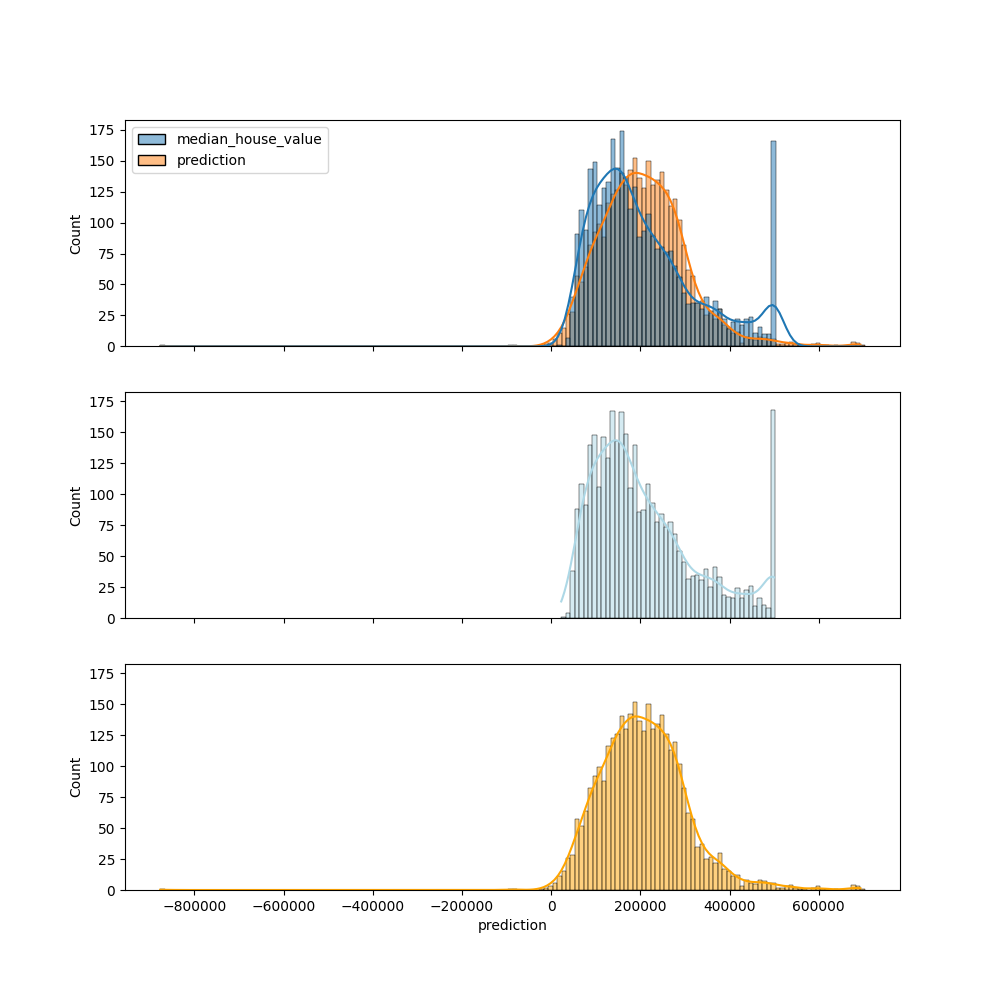

In [14]:
%%python

import itertools

lr_prediction = spark.table("lr_prediction").select("median_house_value","prediction").toPandas()

f, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)

sns.histplot(data=lr_prediction, binwidth=10000, kde=True, ax=axes[0])
sns.histplot(data=lr_prediction, x="median_house_value", binwidth=10000, kde=True, color="lightblue", ax=axes[1])
sns.histplot(data=lr_prediction, x="prediction", binwidth=10000, kde=True, color="orange", ax=axes[2])

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

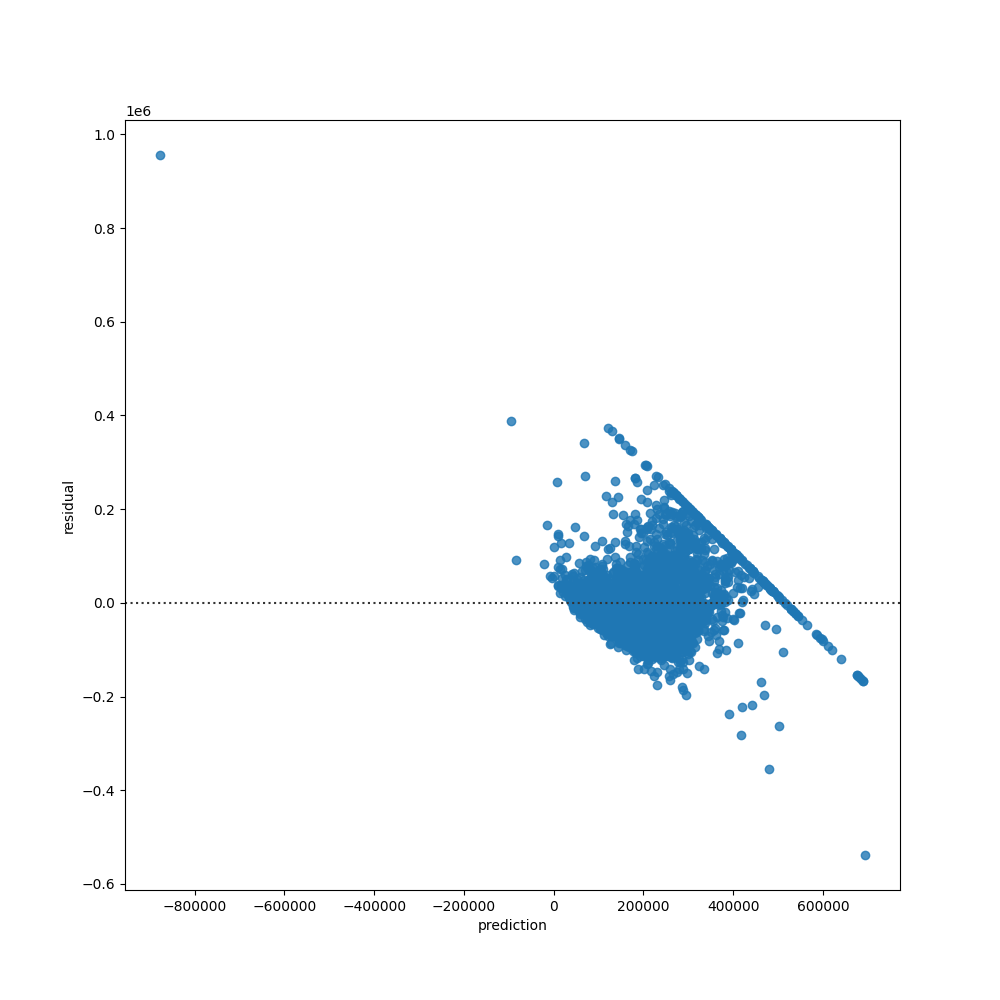

In [15]:
%%python

plt.clf()

lr_error = spark.table("lr_error").select("prediction","residual").toPandas()

sns.residplot(data=lr_error, x="prediction", y="residual")

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

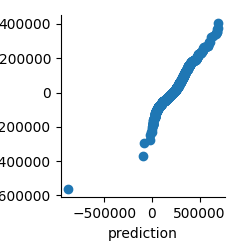

In [16]:
%%python

from seaborn_qqplot import pplot

plt.clf()

lr_error = spark.table("lr_error").select("prediction","residual").toPandas()

##sns.residplot(data=lr_error, x="prediction", y="residual")

pplot(lr_error, x="prediction", y="residual", kind='qq')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)



# Decision Tree

In [17]:
import org.apache.spark.ml.regression.DecisionTreeRegressionModel

val dt = new DecisionTreeRegressor()
  .setLabelCol("median_house_value")
  .setFeaturesCol("scaled_features")

val dt_pipeline = new Pipeline()
    .setStages(Array(data_pipeline,dt))

val dt_fitted_model = dt_pipeline.fit(train)

val dt_model = dt_fitted_model.stages(1).asInstanceOf[DecisionTreeRegressionModel]
dt_model.toDebugString

import org.apache.spark.ml.regression.DecisionTreeRegressionModel
dt: org.apache.spark.ml.regression.DecisionTreeRegressor = dtr_6f7446766633
dt_pipeline: org.apache.spark.ml.Pipeline = pipeline_c2f008bb0634
dt_fitted_model: org.apache.spark.ml.PipelineModel = pipeline_c2f008bb0634
dt_model: org.apache.spark.ml.regression.DecisionTreeRegressionModel = DecisionTreeRegressionModel: uid=dtr_6f7446766633, depth=5, numNodes=63, numFeatures=15
res7: String =
"DecisionTreeRegressionModel: uid=dtr_6f7446766633, depth=5, numNodes=63, numFeatures=15
  If (feature 7 <= 2.656123084547575)
   If (feature 12 <= 1.0746582256571788)
    If (feature 9 <= 0.21129196705932474)
     If (feature 7 <= 1.5836251151102414)
      If (feature 1 <= 17.682858694288306)
       Predict: 216186.0893939394
      Else ...


In [18]:
val dt_prediction = dt_fitted_model.transform(validation)
dt_prediction.createOrReplaceTempView("dt_prediction")

val dt_error = dt_prediction.withColumn("residual", $"median_house_value" - $"prediction")
dt_error.cache()
dt_error.createOrReplaceTempView("dt_error")

dt_prediction: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 17 more fields]
dt_error: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 18 more fields]


In [19]:
val dt_evaluator = new RegressionEvaluator()
    .setLabelCol("median_house_value")
    .setPredictionCol("prediction")
val dt_evaluation = dt_evaluator.evaluate(dt_prediction)
dt_evaluation

dt_evaluator: org.apache.spark.ml.evaluation.RegressionEvaluator = RegressionEvaluator: uid=regEval_d9dc37eaccdc, metricName=rmse, throughOrigin=false
dt_evaluation: Double = 69116.8824899064
res9: Double = 69116.8824899064


In [20]:
dt_prediction.select("median_house_value","prediction").describe().show

+-------+------------------+-----------------+
|summary|median_house_value|       prediction|
+-------+------------------+-----------------+
|  count|              3349|             3349|
|   mean| 207996.4640191102|206941.3358980259|
| stddev|117947.90986508696|97537.30599493798|
|    min|           22500.0|75648.56945917285|
|    max|          500001.0|482368.0533807829|
+-------+------------------+-----------------+



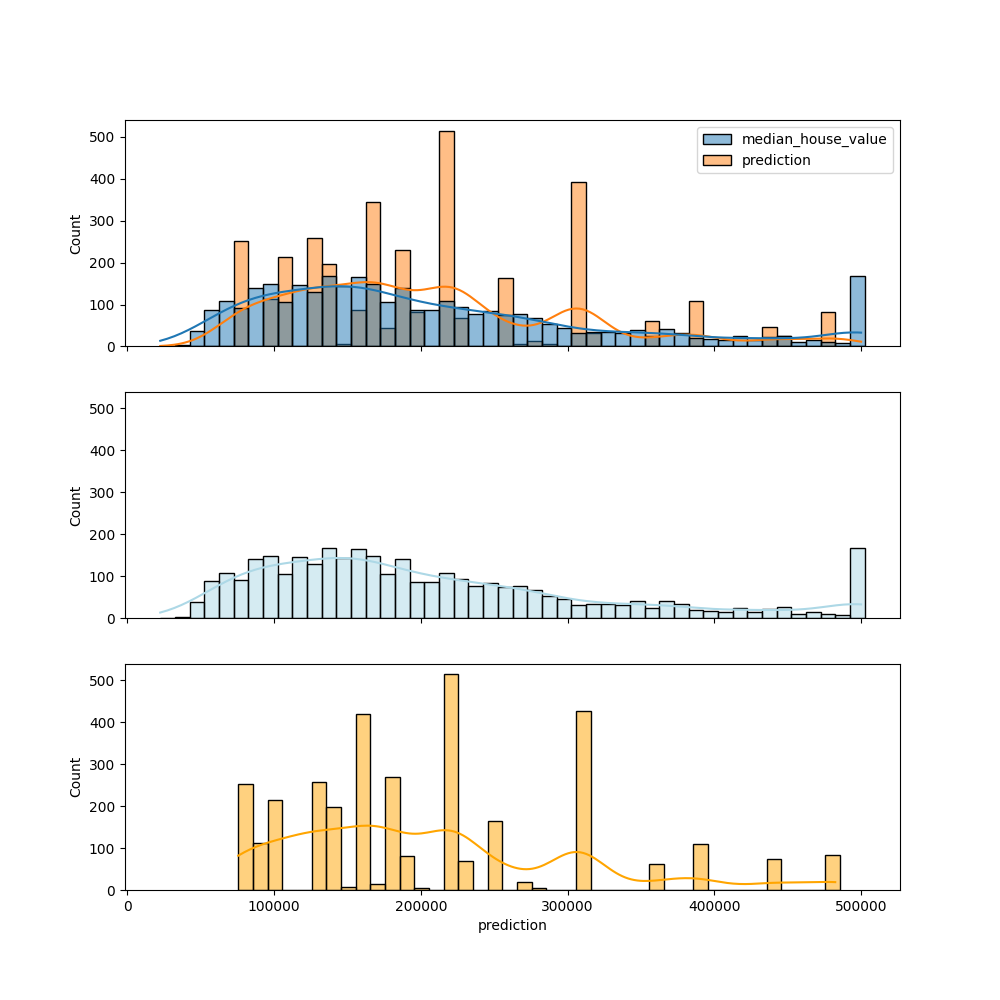

In [21]:
%%python


dt_prediction = spark.table("dt_prediction").select("median_house_value","prediction").toPandas()

f, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)

sns.histplot(data=dt_prediction, binwidth=10000, kde=True ,ax=axes[0])
sns.histplot(data=dt_prediction, x="median_house_value", binwidth=10000, kde=True, color="lightblue", ax=axes[1])
sns.histplot(data=dt_prediction, x="prediction", binwidth=10000, kde=True, color="orange", ax=axes[2])

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

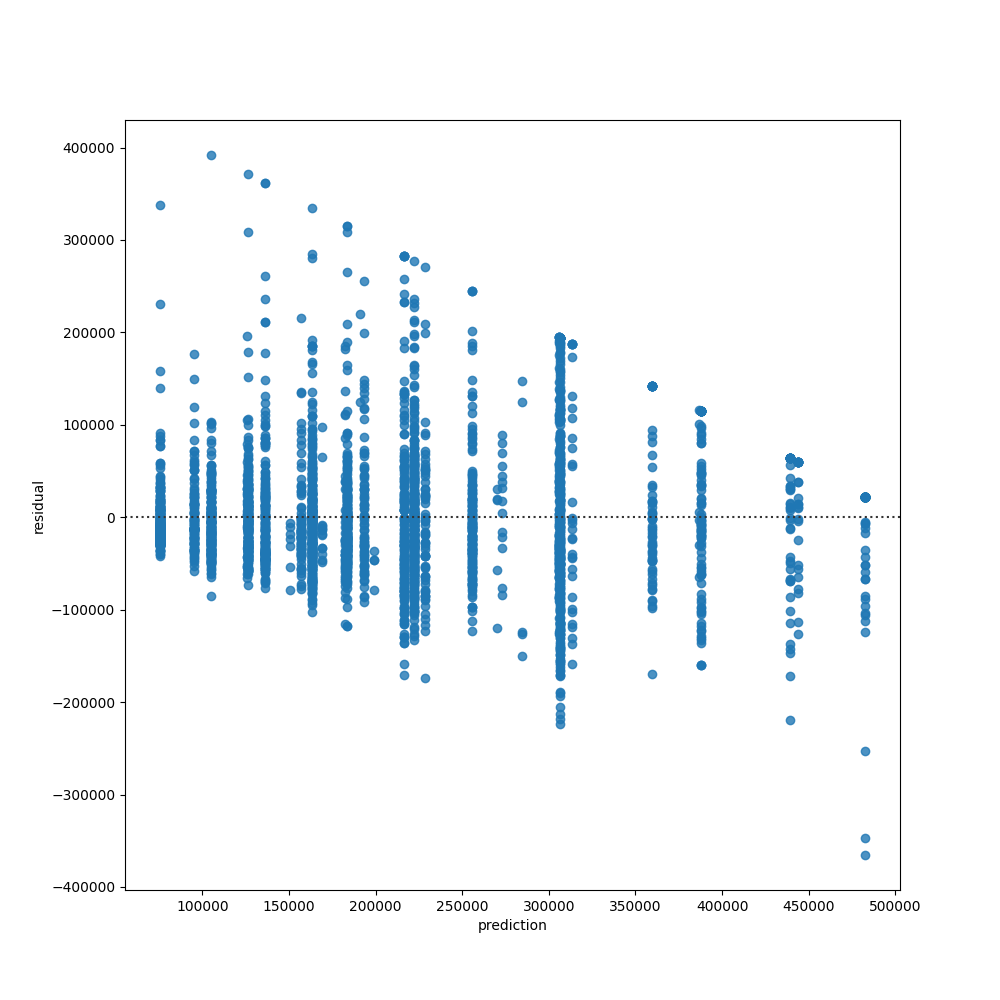

In [22]:
%%python

plt.clf()

plt.figure(figsize=(10,10))


dt_error = spark.table("dt_error").select("prediction","residual").toPandas()

sns.residplot(data=dt_error, x="prediction", y="residual")

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

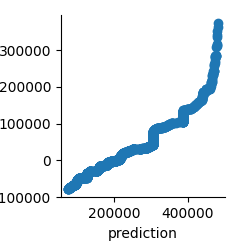

In [23]:
%%python

from seaborn_qqplot import pplot

plt.clf()

plt.figure(figsize=(10,10))

dt_error = spark.table("dt_error").select("prediction","residual").toPandas()

pplot(dt_error, x="prediction", y="residual", kind='qq')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)



# Random Forest

In [24]:

import org.apache.spark.ml.regression.{RandomForestRegressionModel, RandomForestRegressor}

val rf = new RandomForestRegressor()
  .setLabelCol("median_house_value")
  .setFeaturesCol("scaled_features")


val rf_pipeline = new Pipeline()
    .setStages(Array(data_pipeline, rf))

val rf_fitted_model = rf_pipeline.fit(train)

val rf_model = rf_fitted_model.stages(1).asInstanceOf[RandomForestRegressionModel]
println(s"Learned regression forest model:\n ${rf_model.toDebugString}")



Learned regression forest model:
 RandomForestRegressionModel: uid=rfr_8e695c907e1d, numTrees=20, numFeatures=15
  Tree 0 (weight 1.0):
    If (feature 7 <= 2.650454292767159)
     If (feature 12 <= 1.0746582256571788)
      If (feature 4 <= 1.7538833180497297)
       If (feature 9 <= 0.22003924960149746)
        If (feature 7 <= 1.584159906787639)
         Predict: 196058.00775193798
        Else (feature 7 > 1.584159906787639)
         Predict: 278209.28949615714
       Else (feature 9 > 0.22003924960149746)
        If (feature 7 <= 1.6439763559045784)
         Predict: 145409.1318458418
        Else (feature 7 > 1.6439763559045784)
         Predict: 202368.08261802574
      Else (feature 4 > 1.7538833180497297)
       If (feature 9 <= 0.2073028730231261)
        If (feature 7 <= 1.8305384325647862)
         Predict: 238147.71854304636
        Else (feature 7 > 1.8305384325647862)
         Predict: 318370.8700361011
       Else (feature 9 > 0.2073028730231261)
        If (feature 7 <

      Else (feature 11 > 1.00619809670737)
       If (feature 3 <= 0.8481011230278248)
        If (feature 7 <= 1.584159906787639)
         Predict: 166231.93712212818
        Else (feature 7 > 1.584159906787639)
         Predict: 220669.46285714285
       Else (feature 3 > 0.8481011230278248)
        If (feature 0 <= -58.86527356213931)
         Predict: 259807.31846473028
        Else (feature 0 > -58.86527356213931)
         Predict: 199086.7679938744
     Else (feature 7 > 2.7651403679851083)
      If (feature 8 <= 2.70207365612871)
       If (feature 9 <= 0.2572608762459432)
        If (feature 0 <= -58.7209776377657)
         Predict: 370818.2212817412
        Else (feature 0 > -58.7209776377657)
         Predict: 289899.2096069869
       Else (feature 9 > 0.2572608762459432)
        If (feature 0 <= -60.711266249815544)
         Predict: 309447.61904761905
        Else (feature 0 > -60.711266249815544)
         Predict: 251262.56511627906
      Else (feature 8 > 2.70207365612871

         Predict: 293354.96078431373
        Else (feature 10 > 2.12416026715613)
         Predict: 214986.90983606558
     Else (feature 2 > 2.1100672874449966)
      If (feature 10 <= 2.2786033200007694)
       If (feature 7 <= 3.6193096351248077)
        If (feature 1 <= 17.668896705583776)
         Predict: 334774.224137931
        Else (feature 1 > 17.668896705583776)
         Predict: 204577.77777777778
       Else (feature 7 > 3.6193096351248077)
        If (feature 1 <= 17.543238807243)
         Predict: 479102.815920398
        Else (feature 1 > 17.543238807243)
         Predict: 415640.2909090909
      Else (feature 10 > 2.2786033200007694)
       If (feature 8 <= 2.503638396415216)
        If (feature 7 <= 3.6193096351248077)
         Predict: 267049.4588235294
        Else (feature 7 > 3.6193096351248077)
         Predict: 463808.3076923077
       Else (feature 8 > 2.503638396415216)
        If (feature 7 <= 3.08917064532041)
         Predict: 285061.74358974356
        Els

         Predict: 288555.42018779344
        Else (feature 2 > 2.2693176487616)
         Predict: 414090.04545454547
       Else (feature 10 > 2.3951765268460834)
        If (feature 2 <= 2.587818371394807)
         Predict: 234263.08695652173
        Else (feature 2 > 2.587818371394807)
         Predict: 366361.3333333333
      Else (feature 7 > 4.198569240498189)
       If (feature 9 <= 0.2528414364297093)
        If (feature 2 <= 1.632316203495186)
         Predict: 442280.34285714285
        Else (feature 2 > 1.632316203495186)
         Predict: 488454.8888888889
       Else (feature 9 > 0.2528414364297093)
        If (feature 7 <= 6.213824718436161)
         Predict: 421800.3113207547
        Else (feature 7 > 6.213824718436161)
         Predict: 488570.0
    Else (feature 10 > 2.5754740914431107)
     If (feature 12 <= 1.0746582256571788)
      If (feature 0 <= -58.86527356213931)
       If (feature 0 <= -60.98990665550252)
        If (feature 7 <= 2.172751626931612)
         Pre

       If (feature 2 <= 3.7025709006110312)
        If (feature 7 <= 1.899259163110398)
         Predict: 190586.29714285713
        Else (feature 7 > 1.899259163110398)
         Predict: 269284.3915662651
       Else (feature 2 > 3.7025709006110312)
        If (feature 1 <= 17.603740758295963)
         Predict: 355238.0128205128
        Else (feature 1 > 17.603740758295963)
         Predict: 211263.63636363635
    Else (feature 7 > 2.7651403679851083)
     If (feature 7 <= 3.6193096351248077)
      If (feature 9 <= 0.22003924960149746)
       If (feature 9 <= 0.19147502563030455)
        If (feature 2 <= 1.632316203495186)
         Predict: 307476.1
        Else (feature 2 > 1.632316203495186)
         Predict: 444012.38613861386
       Else (feature 9 > 0.19147502563030455)
        If (feature 6 <= 0.7411638500041193)
         Predict: 319080.9682539682
        Else (feature 6 > 0.7411638500041193)
         Predict: 349926.8526785714
      Else (feature 9 > 0.22003924960149746)
     

        Else (feature 10 > 2.8282134245877595)
         Predict: 227616.2458006719
    Else (feature 12 > 1.0746582256571788)
     If (feature 8 <= 2.388000166911338)
      If (feature 8 <= 2.165678211242426)
       If (feature 0 <= -58.92000649897068)
        If (feature 1 <= 17.389656931493157)
         Predict: 70047.76119402985
        Else (feature 1 > 17.389656931493157)
         Predict: 104074.78591817316
       Else (feature 0 > -58.92000649897068)
        If (feature 1 <= 15.723526279419145)
         Predict: 73838.33333333333
        Else (feature 1 > 15.723526279419145)
         Predict: 125931.40706319702
      Else (feature 8 > 2.165678211242426)
       If (feature 3 <= 0.9307472422371053)
        If (feature 7 <= 2.021967113489314)
         Predict: 99865.71428571429
        Else (feature 7 > 2.021967113489314)
         Predict: 154520.65217391305
       Else (feature 3 > 0.9307472422371053)
        If (feature 5 <= 0.9685167161025017)
         Predict: 119701.6129032258

        Else (feature 4 > 2.3138654140683714)
         Predict: 353825.1388888889
       Else (feature 10 > 2.5754740914431107)
        If (feature 1 <= 17.543238807243)
         Predict: 329655.3965517241
        Else (feature 1 > 17.543238807243)
         Predict: 196505.55555555556
      Else (feature 12 > 1.0746582256571788)
       If (feature 0 <= -58.86527356213931)
        If (feature 0 <= -60.223645539863334)
         Predict: 182919.39130434784
        Else (feature 0 > -60.223645539863334)
         Predict: 143132.12669683257
       Else (feature 0 > -58.86527356213931)
        If (feature 7 <= 3.08917064532041)
         Predict: 168971.1443298969
        Else (feature 7 > 3.08917064532041)
         Predict: 307434.3048780488
     Else (feature 11 > 1.00619809670737)
      If (feature 7 <= 3.6193096351248077)
       If (feature 0 <= -58.40750718136785)
        If (feature 7 <= 3.08917064532041)
         Predict: 262178.25641025644
        Else (feature 7 > 3.08917064532041)
 

       If (feature 7 <= 2.1062770214310707)
        If (feature 2 <= 1.632316203495186)
         Predict: 113959.93265993266
        Else (feature 2 > 1.632316203495186)
         Predict: 97271.01449275362
       Else (feature 7 > 2.1062770214310707)
        If (feature 7 <= 3.08917064532041)
         Predict: 168669.34865900382
        Else (feature 7 > 3.08917064532041)
         Predict: 266253.68292682926
     Else (feature 0 > -58.92000649897068)
      If (feature 7 <= 2.4292644549954465)
       If (feature 0 <= -58.40750718136785)
        If (feature 0 <= -58.68614758705482)
         Predict: 179925.1870503597
        Else (feature 0 > -58.68614758705482)
         Predict: 134074.04746835443
       Else (feature 0 > -58.40750718136785)
        If (feature 3 <= 1.1646426659603057)
         Predict: 88722.54248366013
        Else (feature 3 > 1.1646426659603057)
         Predict: 112927.69421487603
      Else (feature 7 > 2.4292644549954465)
       If (feature 10 <= 2.27860332000076

         Predict: 228365.9233716475
     Else (feature 7 > 2.172751626931612)
      If (feature 12 <= 1.0746582256571788)
       If (feature 8 <= 2.5903169583894154)
        If (feature 9 <= 0.22003924960149746)
         Predict: 339074.6220391349
        Else (feature 9 > 0.22003924960149746)
         Predict: 238350.14788732395
       Else (feature 8 > 2.5903169583894154)
        If (feature 9 <= 0.2438703777076081)
         Predict: 396266.54411764705
        Else (feature 9 > 0.2438703777076081)
         Predict: 302187.29032258067
      Else (feature 12 > 1.0746582256571788)
       If (feature 4 <= 0.46907591160003137)
        If (feature 6 <= 0.47333719937651275)
         Predict: 150694.0
        Else (feature 6 > 0.47333719937651275)
         Predict: 108677.77777777778
       Else (feature 4 > 0.46907591160003137)
        If (feature 2 <= 2.7470687327114103)
         Predict: 168873.20718232045
        Else (feature 2 > 2.7470687327114103)
         Predict: 234445.45454545456


import org.apache.spark.ml.regression.{RandomForestRegressionModel, RandomForestRegressor}
rf: org.apache.spark.ml.regression.RandomForestRegressor = rfr_8e695c907e1d
rf_pipeline: org.apache.spark.ml.Pipeline = pipeline_5b06b6ba76f3
rf_fitted_model: org.apache.spark.ml.PipelineModel = pipeline_5b06b6ba76f3
rf_model: org.apache.spark.ml.regression.RandomForestRegressionModel = RandomForestRegressionModel: uid=rfr_8e695c907e1d, numTrees=20, numFeatures=15


In [25]:
val rf_prediction = rf_fitted_model.transform(validation)
rf_prediction.createOrReplaceTempView("rf_prediction")

val rf_error = dt_prediction.withColumn("residual", $"median_house_value" - $"prediction")
rf_error.cache()
rf_error.createOrReplaceTempView("rf_error")

rf_prediction: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 17 more fields]
rf_error: org.apache.spark.sql.DataFrame = [longitude: double, latitude: double ... 18 more fields]


In [26]:
val rf_evaluator = new RegressionEvaluator()
    .setLabelCol("median_house_value")
    .setPredictionCol("prediction")
val rf_evaluation = rf_evaluator.evaluate(rf_prediction)
rf_evaluation

rf_evaluator: org.apache.spark.ml.evaluation.RegressionEvaluator = RegressionEvaluator: uid=regEval_64874ec825ab, metricName=rmse, throughOrigin=false
rf_evaluation: Double = 66844.59732823946
res13: Double = 66844.59732823946


In [27]:
rf_prediction.select("median_house_value","prediction").describe().show

+-------+------------------+------------------+
|summary|median_house_value|        prediction|
+-------+------------------+------------------+
|  count|              3349|              3349|
|   mean| 207996.4640191102|206982.18037263717|
| stddev|117947.90986508696| 83335.52598231973|
|    min|           22500.0| 86566.27592061364|
|    max|          500001.0|474901.74078600015|
+-------+------------------+------------------+



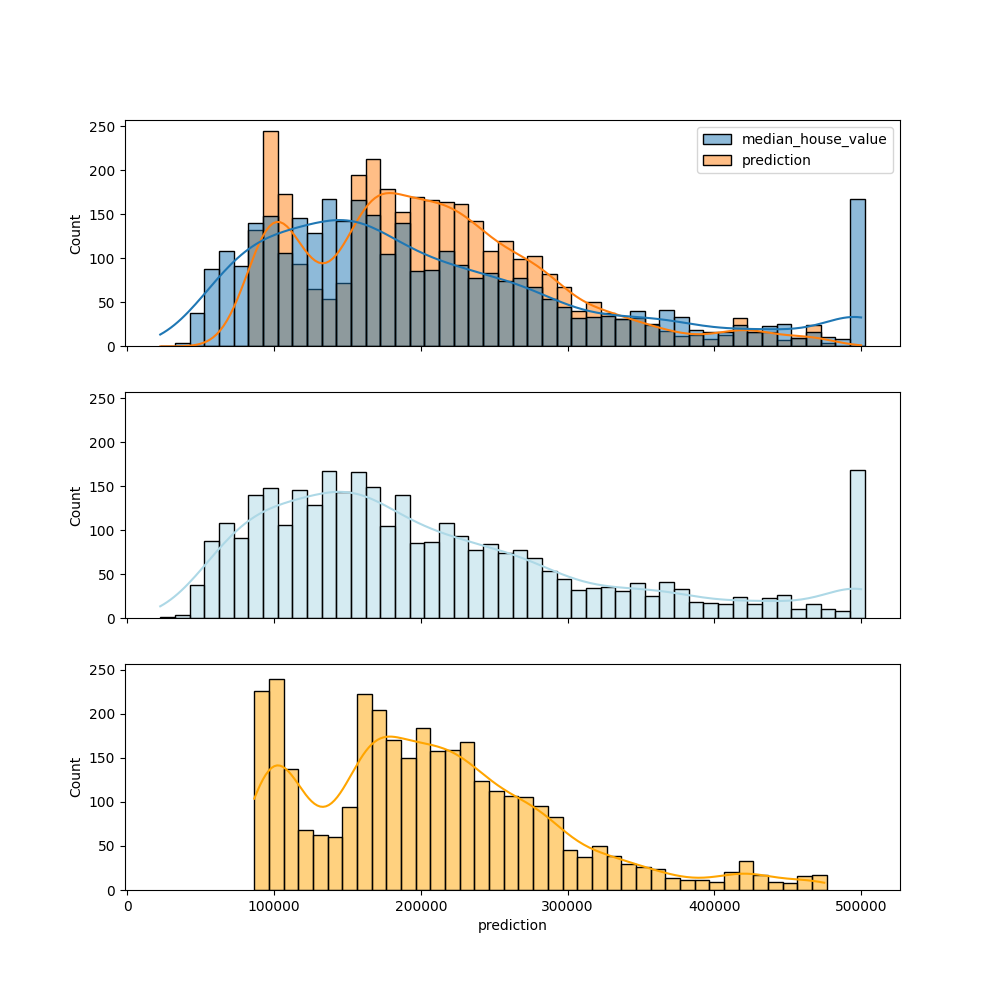

In [28]:
%%python

rf_prediction = spark.table("rf_prediction").select("median_house_value","prediction").toPandas()

f, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)

sns.histplot(data=rf_prediction, binwidth=10000, kde=True ,ax=axes[0])
sns.histplot(data=rf_prediction, x="median_house_value", binwidth=10000, kde=True, color="lightblue", ax=axes[1])
sns.histplot(data=rf_prediction, x="prediction", binwidth=10000, kde=True, color="orange", ax=axes[2])

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

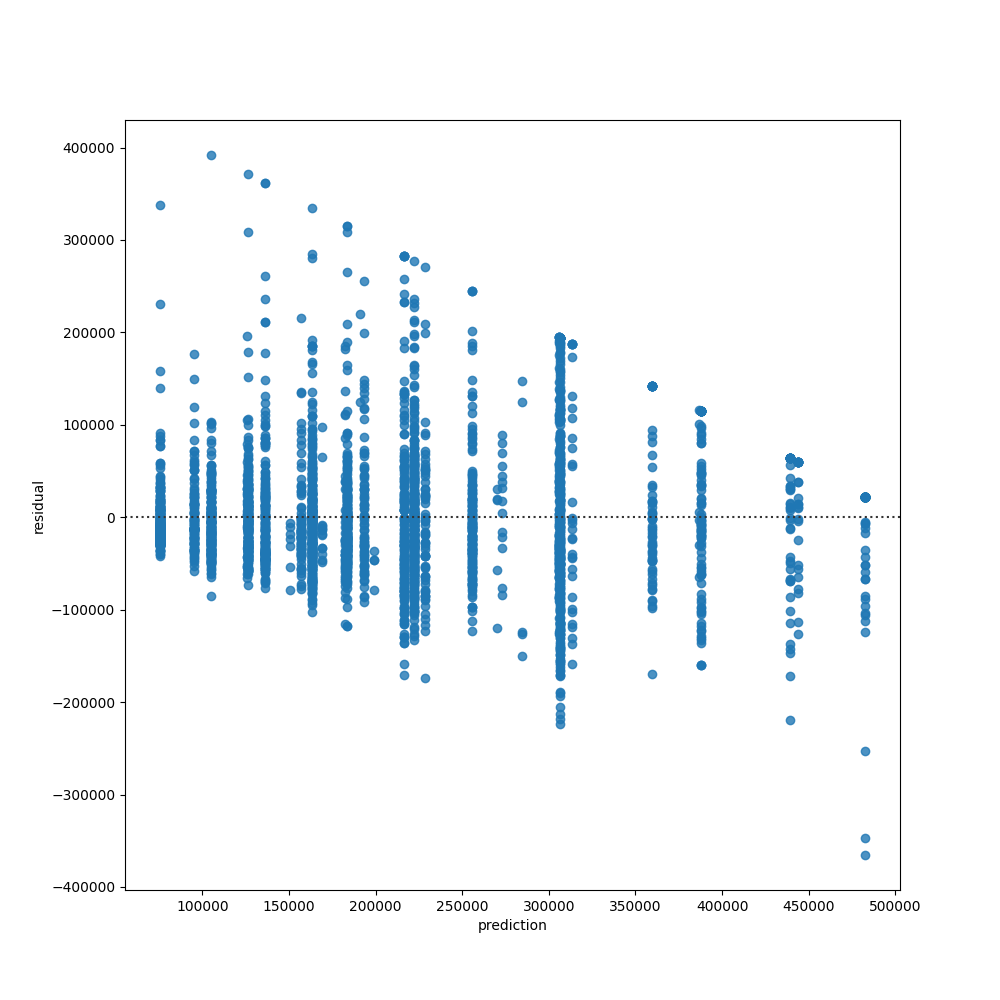

In [29]:
%%python

plt.clf()

plt.figure(figsize=(10,10))

rf_error = spark.table("rf_error").select("prediction","residual").toPandas()

sns.residplot(data=rf_error, x="prediction", y="residual")

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

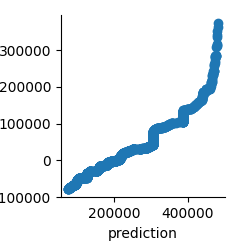

In [30]:
%%python

from seaborn_qqplot import pplot

plt.clf()

plt.figure(figsize=(10,10))

rf_error = spark.table("rf_error").select("prediction","residual").toPandas()

pplot(rf_error, x="prediction", y="residual", kind='qq')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)